# Initial Setups

## (Google Colab use only)

In [1]:
# Use Google Colab
use_colab = False

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')

    # cd to the appropriate working directory under my Google Drive
    %cd '/content/drive/My Drive/cs696ds_lexalytics/Prompting Experiments'
    
    # Install packages specified in requirements
    !pip install -r requirements.txt
    
    # List the directory contents
    !ls

## Experiment parameters

In [2]:
# We will use the following string ID to identify this particular (training) experiments
# in directory paths and other settings
experiment_id = 'bert_prompt_lr_atsc_laptops_bert-base-uncased_multiple_prompts'

# Random seed
random_seed = 696

# path to pretrained MLM model folder or the string "bert-base-uncased"
lm_model_path = "bert-base-uncased"

# Prompts to be added to the end of each review text
sentiment_prompts = [
    "The {aspect} is [MASK].",
    "I [MASK] the {aspect}.",
    "I felt the {aspect} was [MASK].",
    "The {aspect} made me feel [MASK]."]

# Multiple prompt merging behavior
prompts_merge_behavior = 'concatenate'

# Perturb the input embeddings of tokens within the prompts
prompts_perturb = False

# Training settings
training_epochs = 20
training_batch_size = 16
training_learning_rate = 2e-5
training_weight_decay = 0.01
training_warmup_steps_duration = 0.15
training_hard_restart_num_cycles = 3
training_max_grad_norm = 1.0
training_best_model_criterion = 'train_loss'
training_domain = 'laptops' # 'laptops', 'restaurants', 'joint'
training_dataset_proportion = 1.0
training_dataset_few_shot_size = None

training_lm_freeze = False

validation_enabled = False
validation_dataset_proportion = 0.2
validation_batch_size = 16

testing_batch_size = 16
testing_domain = 'laptops' # 'laptops', 'restaurants', 'joint'

In [3]:
# Parameters
experiment_id = "bert_64_shot_prompt_lr_concatenate_perturb_atsc_laptops_bert_amazon_electronics_single_prompt_i_felt_683"
random_seed = 683
lm_model_path = "../progress/lm_further_pretraining_bert_amazon_electronics_bseoh_2021-03-06--18_59_53/results/checkpoint-1180388"
training_domain = "laptops"
sentiment_prompts = ["I felt the {aspect} was [MASK]."]
training_dataset_few_shot_size = 64
testing_batch_size = 32
testing_domain = "laptops"
prompts_merge_behavior = "concatenate"
prompts_perturb = True


In [4]:
# Batch size adjustment for multiple prompts.
training_batch_size = training_batch_size // len(sentiment_prompts)

In [5]:
print("Experiment ID:", experiment_id)

Experiment ID: bert_64_shot_prompt_lr_concatenate_perturb_atsc_laptops_bert_amazon_electronics_single_prompt_i_felt_683


## Package imports

In [6]:
import sys
import os
import random
import shutil
import copy
import inspect
import json

import numpy as np
import torch
import transformers
import datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tqdm

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import utils

# Random seed settings
random.seed(random_seed)
np.random.seed(random_seed)

# cuBLAS reproducibility
# https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
torch.set_deterministic(True)
torch.manual_seed(random_seed)

# Print version information
print("Python version: " + sys.version)
print("NumPy version: " + np.__version__)
print("PyTorch version: " + torch.__version__)
print("Transformers version: " + transformers.__version__)

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


Python version: 3.7.9 (default, Nov  4 2020, 21:30:07) 
[GCC 7.3.0]
NumPy version: 1.19.2
PyTorch version: 1.7.1
Transformers version: 4.3.3


## PyTorch GPU settings

In [7]:
if torch.cuda.is_available():    
    torch_device = torch.device('cuda')

    # Set this to True to make your output immediately reproducible
    # Note: https://pytorch.org/docs/stable/notes/randomness.html
    torch.backends.cudnn.deterministic = True
    
    # Disable 'benchmark' mode: Set this False if you want to measure running times more fairly
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    
    # Faster Host to GPU copies with page-locked memory
    use_pin_memory = True
    
    # Number of compute devices to be used for training
    training_device_count = torch.cuda.device_count()

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
    print("Number of CUDA devices: "+ str(training_device_count))
    
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False
    
    # Number of compute devices to be used for training
    training_device_count = 1

print()
print("PyTorch device selected:", torch_device)

CUDA Version: 11.0
cuDNN Version: 8005
CUDA Device Name: GeForce GTX TITAN X
CUDA Capabilities: (5, 2)
Number of CUDA devices: 1

PyTorch device selected: cuda


# Prepare Datasets for Prompt-based Classifier

## Load the SemEval dataset

In [8]:
# Load semeval for both domains
laptops_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Laptops_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Laptop_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

restaurants_dataset = datasets.load_dataset(
    os.path.abspath('../dataset_scripts/semeval2014_task4/semeval2014_task4.py'),
    data_files={
        'test': '../dataset_files/semeval_2014/Restaurants_Test_Gold.xml',
        'train': '../dataset_files/semeval_2014/Restaurants_Train_v2.xml',
    },
    cache_dir='../dataset_cache')

Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-47641dbbf5e749c1/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


Using custom data configuration default


Reusing dataset sem_eval2014_task4_dataset (../dataset_cache/sem_eval2014_task4_dataset/default-7fe90f8b66ac6023/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969)


In [9]:
# The dataset chosen for training/testing
print("Training domain:", training_domain)
print("Testing domain:", testing_domain)

if training_domain == 'laptops':
    train_set = laptops_dataset['train']
elif training_domain == 'restaurants':
    train_set = restaurants_dataset['train']
elif training_domain == 'joint':
    train_set = laptops_dataset['train'] + restaurants_dataset['train']

if testing_domain == 'laptops':
    test_set = laptops_dataset['test']
elif testing_domain == 'restaurants':
    test_set = restaurants_dataset['test']
elif testing_domain == 'joint':
    test_set = laptops_dataset['test'] + restaurants_dataset['test']

Training domain: laptops
Testing domain: laptops


## Train-validation split

In [10]:
# Training set size after validation split
if validation_enabled:
    new_train_dataset_size = int(int(len(train_set) * training_dataset_proportion) * (1 - validation_dataset_proportion))
    new_valid_dataset_size = int(len(train_set) * training_dataset_proportion) - new_train_dataset_size

    print("Training dataset after split:", new_train_dataset_size)
    print("Validation dataset after split:", new_train_dataset_size)
else:
    new_train_dataset_size = int(len(train_set) * training_dataset_proportion)

    print("Training dataset size:", new_train_dataset_size)

Training dataset size: 2313


In [11]:
train_set = train_set.shuffle(seed=random_seed)

new_train_set = train_set.select(indices=np.arange(new_train_dataset_size))

if validation_enabled:
    new_valid_set = train_set.select(
        indices=np.arange(
            new_train_dataset_size,
            new_train_dataset_size + new_valid_dataset_size))

Loading cached shuffled indices for dataset at ../dataset_cache/sem_eval2014_task4_dataset/default-47641dbbf5e749c1/0.0.1/f33ba7108331ad17be3f9fb710ca001edb383fba797c6ed0938354e6812ca969/cache-b266f6053c1c9cc2.arrow


In [12]:
# For few shot experiments, select first few examples in new_train_set for training
if training_dataset_few_shot_size is not None:
    new_train_set = new_train_set.select(indices=np.arange(training_dataset_few_shot_size))
    
    print("Few-shot training dataset size:", len(new_train_set))

Few-shot training dataset size: 64


In [13]:
print(new_train_set[0])

{'aspect': 'internet', 'sentiment': 1, 'text': 'The internet was locekd and froze every time it was trying to be used, and the command prompt would not work at all.'}


# Zero-shot ATSC with Prompts + Linear Head

## Load the pretrained LM

In [14]:
# Load pretrained language model
lm = transformers.AutoModelForMaskedLM.from_pretrained(lm_model_path)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='../bert_base_cache')

In [15]:
# Freeze the MLM main layer
if training_lm_freeze:
    for param in lm.parameters():
        param.requires_grad = False

## Define a new model with linear head

In [16]:
classifier_model = utils.MultiPromptSentimentClassificationHead(
    lm=lm,
    num_class=3,
    num_prompts=len(sentiment_prompts),
    target_token_id=tokenizer.mask_token_id,
    merge_behavior=prompts_merge_behavior,
    perturb_prompts=prompts_perturb)

classifier_model = classifier_model.to(device=torch_device)

Detected LM type: bert


In [17]:
if training_lm_freeze:
    # Recheck whether the MLM main layer is frozen
    for param in classifier_model.lm.bert.parameters():
        assert param.requires_grad == False

    # classifier_model.linear should be trainable
    for param in classifier_model.linear.parameters():
        assert param.requires_grad == True

## Training settings

In [18]:
train_dataloader = torch.utils.data.DataLoader(
    new_train_set, shuffle=True, batch_size=training_batch_size, pin_memory=use_pin_memory)

if validation_enabled:
    validation_dataloader = torch.utils.data.DataLoader(
        new_valid_set, batch_size=validation_batch_size, pin_memory=use_pin_memory)

In [19]:
# How many training steps would we have?
training_total_steps = len(train_dataloader) * training_epochs

print("There will be %d training steps." % training_total_steps)

# Let's have warmups for the first (training_warmup_steps_duration)% of steps.
training_warmup_steps = int(training_total_steps * training_warmup_steps_duration)

print("Warmup steps:", training_warmup_steps)

There will be 80 training steps.
Warmup steps: 12


In [20]:
loss_function = torch.nn.CrossEntropyLoss()

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in classifier_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': training_weight_decay},
    {'params': [p for n, p in classifier_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = transformers.AdamW(
    optimizer_grouped_parameters,
    lr=training_learning_rate,
    weight_decay=training_weight_decay)

scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_warmup_steps,
    num_training_steps=training_total_steps,
    num_cycles=training_hard_restart_num_cycles
)

# The directory to save the best version of the head
trained_model_directory = os.path.join('..', 'trained_models_prompts', experiment_id)

shutil.rmtree(trained_model_directory, ignore_errors=True)
os.makedirs(trained_model_directory)

In [21]:
def compute_metrics(predictions, labels):
    preds = predictions.argmax(-1)

    precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(
        y_true=labels, y_pred=preds, labels=[0,1,2], average='macro')

    acc = sklearn.metrics.accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training loop

In [22]:
best_epoch = -1

if training_best_model_criterion in ('train_loss', 'valid_loss'):
    best_score = float('inf')
else:
    best_score = -1

for epoch in tqdm.notebook.tqdm(range(int(training_epochs))):

    print("Training epoch %d" % epoch)
    print()

    classifier_model.train()

    for batch in tqdm.notebook.tqdm(train_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch["text"]

            for aspect in batch["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')
        
        batch_encoded = batch_encoded.to(torch_device)

        batch_label = batch["sentiment"]
        batch_label = batch_label.to(torch_device)

        optimizer.zero_grad()

        batch_output = classifier_model(batch_encoded)
        
        loss = loss_function(batch_output, batch_label)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(classifier_model.parameters(), training_max_grad_norm)

        optimizer.step()
        scheduler.step()
        
    print("Epoch {}, Training Loss: {}".format(epoch, loss.item()))
    print()
    
    # Validate the model using val dataset
    if validation_enabled:
        with torch.no_grad():
            classifier_model.eval()

            print("Validation epoch %d" % epoch)
            print()

            predictions_val = torch.Tensor()
            labels_val = torch.Tensor()

            for batch_val in tqdm.notebook.tqdm(validation_dataloader):

                reviews_repeated = []
                prompts_populated = []

                for prompt in sentiment_prompts:
                    reviews_repeated = reviews_repeated + batch_val["text"]

                    for aspect in batch_val["aspect"]:
                        prompts_populated.append(prompt.format(aspect=aspect))

                batch_val_encoded = tokenizer(
                    reviews_repeated, prompts_populated,
                    padding='max_length', truncation='only_first', max_length=256,
                    return_tensors='pt')

                batch_val_encoded.to(torch_device)

                batch_val_label = batch_val["sentiment"]

                batch_val_output = classifier_model(batch_val_encoded)

                batch_val_output = batch_val_output.to('cpu')

                predictions_val = torch.cat([predictions_val, batch_val_output])
                labels_val = torch.cat([labels_val, batch_val_label])

            # Compute metrics
            validation_loss = torch.nn.functional.cross_entropy(predictions_val, labels_val.long())
            validation_metrics = compute_metrics(predictions_val, labels_val)

            print("Validation Loss: {}, Validation Metrics: {}".format(validation_loss.item(), validation_metrics))
            print()

    if training_best_model_criterion == 'train_loss':
        epoch_score = loss.item()
    elif training_best_model_criterion == 'valid_loss':
        epoch_score = validation_loss.item()
        
    if training_best_model_criterion in ('train_loss', 'valid_loss'):
        better_model_found = epoch_score < best_score
    else:
        better_model_found = epoch_score > best_score

    # Save the current epoch's model if the validation loss is lower than the best known so far
    if better_model_found:
        if best_epoch != -1:
            try:
                os.remove(os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)))
            except:
                pass

        best_score = epoch_score
        best_epoch = epoch

        torch.save(
            classifier_model.state_dict(),
            os.path.join(trained_model_directory, 'epoch_{}.pt'.format(epoch)))

  0%|          | 0/20 [00:00<?, ?it/s]

Training epoch 0



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0, Training Loss: 1.0506651401519775



Training epoch 1



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.0287692546844482



Training epoch 2



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.1163825988769531

Training epoch 3



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.0344481468200684

Training epoch 4



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.7772186398506165



Training epoch 5



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.7091094255447388



Training epoch 6



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.6324100494384766



Training epoch 7



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.6477724313735962

Training epoch 8



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.6274974942207336



Training epoch 9



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.5020564794540405



Training epoch 10



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.37252065539360046



Training epoch 11



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.3518771827220917



Training epoch 12



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.21434056758880615



Training epoch 13



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.15347984433174133



Training epoch 14



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.17447036504745483

Training epoch 15



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.07602691650390625



Training epoch 16



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.0406913235783577



Training epoch 17



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.03666353225708008



Training epoch 18



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.02273983508348465



Training epoch 19



  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.02930765599012375



## Evaluation with in-domain test set



In [23]:
test_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=testing_batch_size, pin_memory=use_pin_memory)

In [24]:
# Load the best found head weights
with torch.no_grad():
    print('Loading epoch {}'.format(best_epoch))

    classifier_model.load_state_dict(torch.load(
        os.path.join(trained_model_directory, 'epoch_{}.pt'.format(best_epoch)),
        map_location=torch_device))

    classifier_model.eval()

    predictions_test = torch.Tensor()
    labels_test = torch.Tensor()

    for batch_test in tqdm.notebook.tqdm(test_dataloader):

        reviews_repeated = []
        prompts_populated = []

        for prompt in sentiment_prompts:
            reviews_repeated = reviews_repeated + batch_test["text"]

            for aspect in batch_test["aspect"]:
                prompts_populated.append(prompt.format(aspect=aspect))

        batch_test_encoded = tokenizer(
            reviews_repeated, prompts_populated,
            padding='max_length', truncation='only_first', max_length=256,
            return_tensors='pt')

        batch_test_encoded.to(torch_device)

        batch_test_label = batch_test["sentiment"]

        batch_test_output = classifier_model(batch_test_encoded)

        batch_test_output = batch_test_output.to('cpu')

        predictions_test = torch.cat([predictions_test, batch_test_output])
        labels_test = torch.cat([labels_test, batch_test_label])

    # Compute metrics
    test_metrics = compute_metrics(predictions_test, labels_test)

    print(test_metrics)
    
    # Save test_metrics into a file for later processing
    with open(os.path.join(trained_model_directory, 'test_metrics.json'), 'w') as test_metrics_json:
        json.dump(test_metrics, test_metrics_json)

Loading epoch 18


  0%|          | 0/20 [00:00<?, ?it/s]

{'accuracy': 0.6144200626959248, 'f1': 0.5937045056233855, 'precision': 0.5956194289527623, 'recall': 0.6310473477618328}


## Results visualization

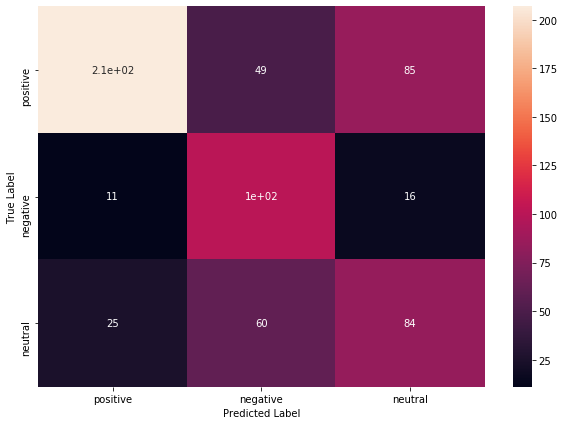

In [25]:
# Calculate metrics and confusion matrix based upon predictions and true labels
cm = sklearn.metrics.confusion_matrix(labels_test.detach().numpy(), predictions_test.detach().numpy().argmax(-1))

df_cm = pd.DataFrame(
    cm,
    index=[i for i in ["positive", "negative", "neutral"]],
    columns=[i for i in ["positive", "negative", "neutral"]])

plt.figure(figsize=(10, 7))

ax = sn.heatmap(df_cm, annot=True)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()